<a href="https://colab.research.google.com/github/Lehel44/crpyto-AI/blob/main/Predict_BitCoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

In [65]:
with open('/content/BTC_hist_daily_prices.json') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data['Data']['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
df = df.drop(['conversionType', 'conversionSymbol'], axis=1 )
target_col = 'close'

df.head(100)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2010-07-17,0.04951,0.04951,0.04951,20.00,0.9902,0.04951
2010-07-18,0.08585,0.05941,0.04951,75.01,5.0920,0.08584
2010-07-19,0.09307,0.07723,0.08584,574.00,49.6600,0.08080
2010-07-20,0.08181,0.07426,0.08080,262.00,20.5900,0.07474
2010-07-21,0.07921,0.06634,0.07474,575.00,42.2600,0.07921
...,...,...,...,...,...,...
2010-10-20,0.10300,0.09400,0.09700,31855.00,3221.0800,0.09900
2010-10-21,0.10900,0.09700,0.09900,44867.00,4616.8500,0.10700
2010-10-22,0.10900,0.10150,0.10700,34603.91,3665.4300,0.10250


In [66]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(df, test_size=0.2)

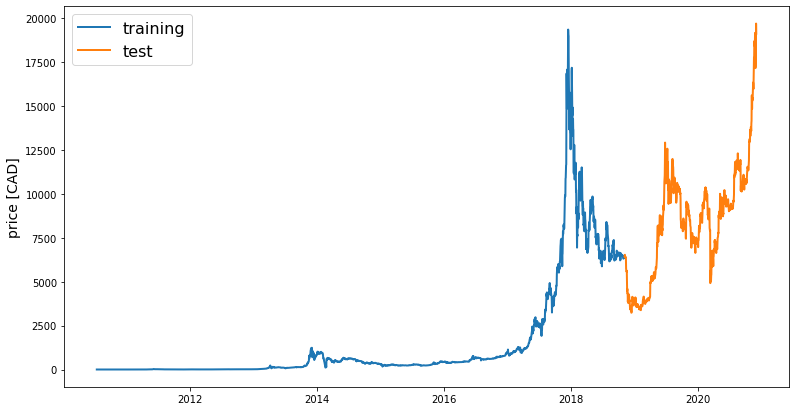

In [67]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [68]:
# Normalize data with min-max scaler

scaler = MinMaxScaler()
print(scaler.fit(df))
print(scaler.transform(df))


MinMaxScaler(copy=True, feature_range=(0, 1))
[[0.00000000e+00 2.10709886e-06 0.00000000e+00 3.49436949e-05
  1.58540276e-10 0.00000000e+00]
 [1.82505392e-06 2.63507352e-06 0.00000000e+00 1.31056328e-04
  8.15276800e-10 1.84539703e-06]
 [2.18765406e-06 3.58542790e-06 1.84539703e-06 1.00288404e-03
  7.95103022e-09 1.58938819e-06]
 ...
 [9.21425754e-01 9.35610557e-01 9.01102872e-01 4.74555644e-02
  7.84023439e-02 9.24434725e-01]
 [9.96908357e-01 9.70567813e-01 9.24434725e-01 1.36254726e-01
  2.39169417e-01 1.00000000e+00]
 [1.00000000e+00 9.70308625e-01 1.00000000e+00 1.53313015e-01
  2.68948489e-01 9.70661591e-01]]


In [69]:
def normalise_zero_base(df):
    return df / df.iloc[0][0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = False
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [106]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [107]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
95/95 [==============================] - 2s 3ms/step - loss: 0.1812
Epoch 2/20
95/95 [==============================] - 0s 4ms/step - loss: 0.1000
Epoch 3/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0895
Epoch 4/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0607
Epoch 5/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0501
Epoch 6/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0475
Epoch 7/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0294
Epoch 8/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0336
Epoch 9/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0610
Epoch 10/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0349
Epoch 11/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0276
Epoch 12/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0328
Epoch 13/20
95/95 [==============================

In [105]:
X_test = extract_window_data(test, window_len, False)
display(X_test[0])
a = np.expand_dims(X_test[0], axis=0)
preds = model.predict(a)
preds

array([[6.47580000e+03, 6.40669000e+03, 6.46705000e+03, 2.41420000e+04,
        1.55758902e+08, 6.43374000e+03],
       [6.48281000e+03, 6.41256000e+03, 6.43353000e+03, 3.71623600e+04,
        2.39808254e+08, 6.47972000e+03],
       [6.56279000e+03, 6.47659000e+03, 6.47972000e+03, 5.51004400e+04,
        3.60052789e+08, 6.52968000e+03],
       [6.54242000e+03, 6.43827000e+03, 6.53094000e+03, 4.20734500e+04,
        2.73205387e+08, 6.44606000e+03],
       [6.45797000e+03, 6.35245000e+03, 6.44606000e+03, 3.70860400e+04,
        2.37893037e+08, 6.37799000e+03]])

array([[0.00288807]], dtype=float32)

In [108]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

#display(preds.shape[0])
arr = np.zeros([preds.shape[0], 6])
arr[:, 5] = preds
display(arr)
#display(arr.shape)

res = scaler.inverse_transform(arr)

df_res = pd.DataFrame(res)

print(df_res)
#mean_absolute_error(preds, y_test)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00840896],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00840896],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00840896],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00840896],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00840896],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00840896]])

           0     1        2    3    4           5
0    0.04951  0.01  0.04951  0.0  0.0  165.595103
1    0.04951  0.01  0.04951  0.0  0.0  165.595103
2    0.04951  0.01  0.04951  0.0  0.0  165.595103
3    0.04951  0.01  0.04951  0.0  0.0  165.595103
4    0.04951  0.01  0.04951  0.0  0.0  165.595103
..       ...   ...      ...  ...  ...         ...
748  0.04951  0.01  0.04951  0.0  0.0  165.595103
749  0.04951  0.01  0.04951  0.0  0.0  165.595103
750  0.04951  0.01  0.04951  0.0  0.0  165.595103
751  0.04951  0.01  0.04951  0.0  0.0  165.595103
752  0.04951  0.01  0.04951  0.0  0.0  165.595103

[753 rows x 6 columns]


array([ 6433.74,  6479.72,  6529.68,  6446.06,  6377.99,  6396.37,
        6408.18,  6375.08,  6339.17,  5741.47,  5647.5 ,  5586.27,
        5568.94,  5615.26,  4809.62,  4441.81,  4593.04,  4320.68,
        4343.42,  3854.11,  4004.15,  3784.59,  3822.99,  4263.55,
        4286.69,  4009.67,  4197.46,  4143.86,  3871.41,  3948.44,
        3737.53,  3485.18,  3420.57,  3461.07,  3592.84,  3467.16,
        3401.02,  3485.59,  3305.11,  3235.48,  3232.51,  3255.37,
        3548.19,  3715.85,  3736.54,  4137.66,  3898.81,  4045.24,
        4007.63,  4081.95,  3834.73,  3848.78,  3646.09,  3947.86,
        3797.06,  3896.21,  3747.39,  3880.15,  3961.01,  3835.86,
        3874.06,  3855.39,  4102.85,  4050.4 ,  4040.75,  4048.34,
        3668.15,  3669.2 ,  3664.38,  3551.24,  3703.9 ,  3621.24,
        3643.99,  3685.3 ,  3648.05,  3729.78,  3567.73,  3571.92,
        3602.04,  3572.05,  3598.52,  3582.89,  3596.5 ,  3565.08,
        3453.42,  3418.25,  3467.21,  3434.13,  3461.63,  3508

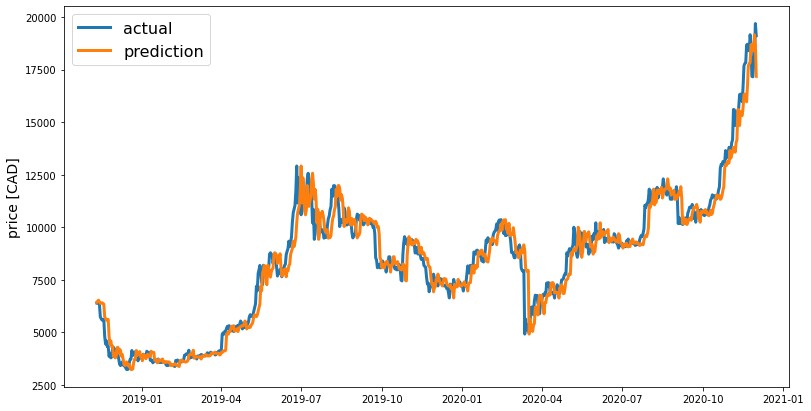

In [ ]:
preds = test[target_col].values[:-window_len]
display(preds)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
a = [1, 2, 3, 4, 5]

a[:-2]

[1, 2, 3]